<a href="https://colab.research.google.com/github/Pushpatejkalapati/NLP_Assessment/blob/main/Text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd

# Load dataset
df = pd.read_csv("/content/sample_data/spam.csv", encoding='latin-1')

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf.fit_transform(df['text'])

In [5]:
from sklearn.decomposition import PCA

# Reduce to 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())


In [6]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0)
kmeans_labels = kmeans.fit_predict(X_tfidf)


In [7]:
from sklearn.cluster import AgglomerativeClustering

hier_cluster = AgglomerativeClustering(n_clusters=2)
hier_labels = hier_cluster.fit_predict(X_tfidf.toarray())

In [8]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.2, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_tfidf)

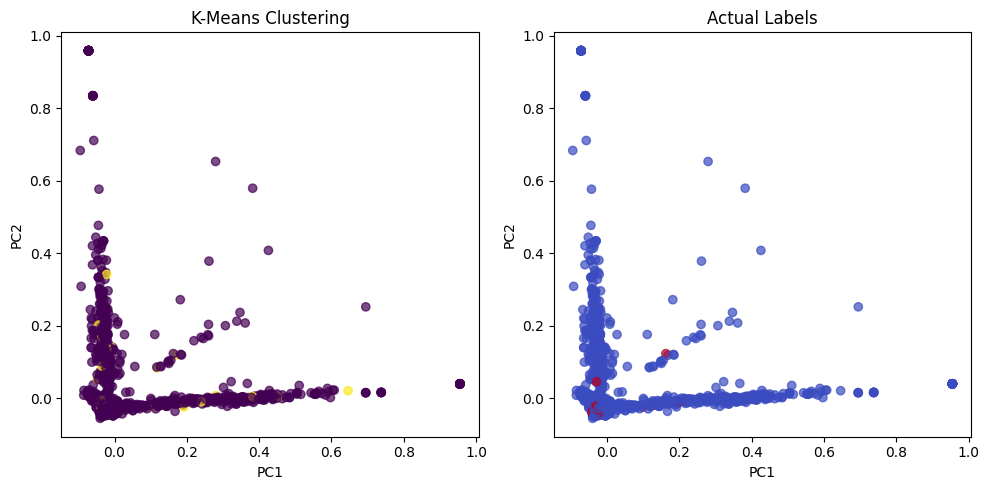

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("K-Means Clustering")
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("PC1"); plt.ylabel("PC2")

plt.subplot(1,2,2)
plt.title("Actual Labels")
label_colors = df['target'].map({'ham':0, 'spam':1})
plt.scatter(X_pca[:,0], X_pca[:,1], c=label_colors, cmap='coolwarm', alpha=0.7)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()